In [ ]:
import jax
import jax.random as jr
import equinox as eqx
from jaxtyping import Int, Array, PRNGKeyArray
from sampling_paths.model import Model
from sampling_paths.utils import random_scene
from differt.scene import TriangleScene
import statistics
from collections import defaultdict

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# jax.config.update("jax_platform_name", "cpu")

In [ ]:
jax.devices()

[CudaDevice(id=0)]

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_673829/2308549371.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


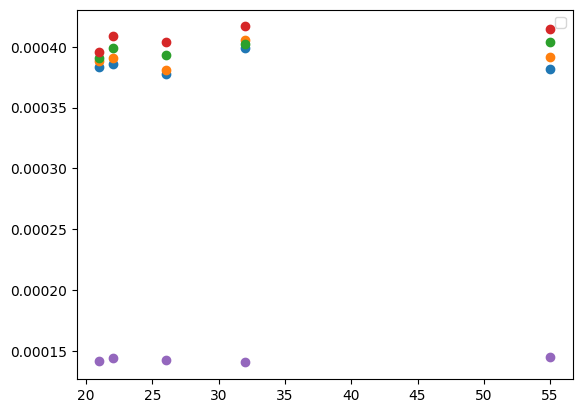

KeyboardInterrupt: 

In [ ]:
key = jr.key(1234)


@eqx.filter_jit
def bench_fun(
    model: Model,
    scene: TriangleScene,
    batch_size: int,
    key: PRNGKeyArray | None,
) -> Int[Array, ""]:
    if key is not None:
        path_candidates = jax.vmap(lambda key: model(scene, key=key))(
            jr.split(key, batch_size)
        )
        paths = scene.compute_paths(path_candidates=path_candidates)
    else:
        paths = scene.compute_paths(order=model.order)
    return paths.mask.sum()


for order, order_key in enumerate(tqdm(jr.split(key, 3)), start=1):
    model_key, stats_key = jr.split(order_key)
    model = Model(
        order=order,
        num_embeddings=64,
        width_size=128,
        depth=2,
        inference=True,
        key=model_key,
    )

    stats = defaultdict(lambda: defaultdict(list))

    for scene_key in tqdm(
        jr.split(stats_key, 1000),
        desc="Collecting statistics over multiple scenes",
        leave=False,
    ):
        scene = random_scene(
            min_fill_factor=0.1,
            max_fill_factor=1.0,
            sample_objects=False,
            include_floor=False,
            key=scene_key,
        )
        # We drop masked objects to reduce the size of the exhaustive search, for a fair comparison
        scene = eqx.tree_at(lambda s: s.mesh, scene, scene.mesh.masked())
        n = scene.mesh.num_primitives
        for batch_size in [1, 10, 100, 1000]:
            # Bench our model (reusing random keys is not a problem here)
            bench_fun(model, scene, batch_size=batch_size, key=jr.key(0))
            %timeit -q -v t bench_fun(model, scene, batch_size=batch_size, key=jr.key(1)).block_until_ready()
            stats[batch_size][n].append(t.average)

        # Bench exhaustive method
        bench_fun(model, scene, batch_size=batch_size, key=None)
        %timeit -q -v t bench_fun(model, scene, batch_size=batch_size, key=None).block_until_ready()
        stats[None][n].append(t.average)

    plt.figure()
    for batch_size in stats:
        ns = []
        ts = []
        for n in stats[batch_size]:
            ns.append(n)
            ts.append(statistics.mean(stats[batch_size][n]))

        label = f"{batch_size = }" if batch_size is not None else "exhaustive"
        plt.scatter(ns, ts, label=label)
    plt.legend()
    plt.savefig(f"benchmarks_{order}.pdf")
    plt.show()